# Importing Libraries

In [ ]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf


# from tensorflow.keras.models import Model
Model = tf.keras.models.Model
Layer = tf.keras.layers.Layer
Conv2D = tf.keras.layers.Conv2D
Dense = tf.keras.layers.Dense
MaxPooling2D = tf.keras.layers.MaxPooling2D
Input = tf.keras.layers.Input
Flatten = tf.keras.layers.Flatten

#Connect my Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Samples Configuration

In [ ]:
POS_PATH = os.path.join('drive', 'MyDrive', 'face_x','data', 'positive')
NEG_PATH = os.path.join('drive', 'MyDrive', 'face_x','data', 'negative')
ANC_PATH = os.path.join('drive', 'MyDrive', 'face_x','data', 'anchor')

lfw_PATH = os.path.join('drive', 'MyDrive', 'face_x', 'lfw')

print(POS_PATH)
print(NEG_PATH)
print(ANC_PATH)
print(lfw_PATH)

drive/MyDrive/face_x/data/positive
drive/MyDrive/face_x/data/negative
drive/MyDrive/face_x/data/anchor
drive/MyDrive/face_x/lfw


In [ ]:
# for path in [POS_PATH, NEG_PATH, ANC_PATH]:
#     os.makedirs(path, exist_ok=True)

# # Process files
# for directory in os.listdir(lfw_PATH):
#     dir_path = os.path.join(lfw_PATH, directory)
#     if os.path.isdir(dir_path):  # Check if it is a directory
#         for file in os.listdir(dir_path):
#             EX_PATH = os.path.join(dir_path, file)
#             NEG_FILE_PATH = os.path.join(NEG_PATH, file)
#             os.replace(EX_PATH, NEG_FILE_PATH)

In [ ]:
# # Import standard dependencies
# import cv2
# import os
# import random
# import numpy as np
# from matplotlib import pyplot as plt
# import uuid


# POS_PATH = os.path.join('data', 'positive')
# NEG_PATH = os.path.join('data', 'negative')
# ANC_PATH = os.path.join('data', 'anchor')


# import uuid
# os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

# # Establish a connection to the webcam
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()

#     # Cut down frame to 250x250px
#     frame = frame[120:120+250,200:200+250, :]

#     # Collect anchors
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         # Create the unique file path
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Write out anchor image
#         cv2.imwrite(imgname, frame)

#     # Collect positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         # Create the unique file path
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Write out positive image
#         cv2.imwrite(imgname, frame)

#     # Show image back to screen
#     cv2.imshow('Image Collection', frame)

#     # Breaking gracefully
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break

# # Release the webcam
# cap.release()
# # Close the image show frame
# cv2.destroyAllWindows()


#Set GPU Growth

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[]

#Ingesting data
Aca recolectamos 300 imagenes de cada grupo:
- Anchor.- Imagen que queremos analizar.
- Positive.- Ejemplo del mismo tipo al anchor.
- Negative.- Ejemplo de un tipo diferente al anchor.

Las fotos de anchor y positive seran reprensentadas por mi belleza y los negativos son fotos de un dataset de figuras publicas.

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [ ]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'drive/MyDrive/face_x/data/anchor/29a4e3f4-a839-11ef-9425-d8bbc14f9174.jpg'


#Preprocessing - Scale and Resize
Aca hacemos un escalamiento y modificacion del tamaño de las imagenes de input.

In [ ]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [ ]:
img = preprocess('drive/MyDrive/face_x/data/anchor/2abd8929-a839-11ef-be25-d8bbc14f9174.jpg')
print(img.numpy().max())
plt.imshow(img)


#Labelling Dataset

Aca lo que hacemos es empezar a etiquetar nuestros datasets, los positivos con 1s y los negativos con 0s. Estos ahora los concatenamos.

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()
exampple = samples.next()
print(exampple)
#print(*exampple)

(b'drive/MyDrive/face_x/data/anchor/1a84bcfa-a839-11ef-8588-d8bbc14f9174.jpg', b'drive/MyDrive/face_x/data/positive/ffdc6fd6-a838-11ef-b78e-d8bbc14f9174.jpg', 1.0)


#Build Train and Test Partition

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*exampple)
plt.imshow(res[1])
print((res[2]))

- Ya teniendo nuestra data como un par: [(( imagenes anchor, imagenes positivas,  1), (imagenes positivas, imagenes negativas, 0))]

- Seguidamente procederemos a que cada para cada par se procese la funcion `preprocess_twin`

- Ya teniendo estos valores preprocesados hacemos el shuffle para evitar patrones en nuestro entrenamiento.



In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

- Tomamos el 70% de los datos.
- Agrupamos los datos en lotes de 16 elementos. Paralelo.
- Prepara 8 lotes en memoria, mientras entrenamos el lote actual.(minimiza la espera)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

- Omitimos el 70% de los primeros datos.... dado esto, ahora tenemos el 30% que no procesamos anteriormente.
- Reafirmamos que solo tomaremos el 30% de los datos... esto es redundante.
- Agrupamos los datos en lotes de 16.


In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

#Model Engineering

In [ ]:
inp = Input(shape=(100,100,3), name='input_image')

In [ ]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [ ]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)


In [ ]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [ ]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [ ]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [ ]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
mod.summary()


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

#Ahora replicaremos la arquitectura de la red neuronal
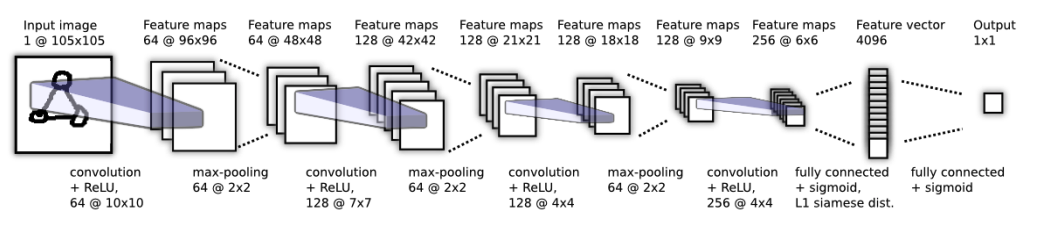

In [ ]:
def make_embedding():
    # 100x100x in 3 channels
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp) # 64 filters size 10x10
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) # Reduces dimensions groupping 2x2

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1) # Reduces vector in 4096 dimensions


    return Model(inputs=[inp], outputs=[d1], name='embedding') # Vector of 4096 dimensions, embedding

In [ ]:
embedding = make_embedding()
embedding.summary()


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

- Recibimos el anchor y la validation(imagen a comparar, puede ser positive o negative) Esto se resta... restamos el vector del anchor y la validation image

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)


l1 = L1Dist()
# l1(anchor_embedding, validation_embedding)


# Siamese Model

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

siamese_layer = L1Dist()

distances = siamese_layer(inp_embedding, val_embedding)

classifier = Dense(1, activation='sigmoid')(distances)

print(classifier)

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_12>


In [ ]:

def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_5 (L1Dist)        │ (1, None, 4096)        │              0 │ embedding[2][0],       │
│                           │                        │                │ embedding[3][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (1, None, 1)           │          4,097 │ l1_dist_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training

## Set up Loss and Optimizer

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001, deep learning


##Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## Build Train Step Function

In [ ]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
print(y)

[0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1.]


In [ ]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = tf.expand_dims(batch[2], axis=-1)
        #y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)

        # Reshape yhat to match y
        yhat = tf.reshape(yhat, (-1, 1)) # Reshape to (16, 1)


        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    tf.print("Loss:", loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

## Training Loop

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## Training Model

In [ ]:
EPOCHS = 50
train(train_data, EPOCHS)



 Epoch 1/50
Loss: 0.693780601
 1/27 ━━━━━━━━━━━━━━━━━━━━ 3:09 7s/stepLoss: 0.691180587
 2/27 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/stepLoss: 0.692271709
 3/27 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/stepLoss: 0.689545393
 4/27 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/stepLoss: 0.680815041
 5/27 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/stepLoss: 0.668364465
 6/27 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/stepLoss: 0.67034173
 7/27 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/stepLoss: 0.634293556
 8/27 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/stepLoss: 0.6659078
 9/27 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/stepLoss: 0.559166312
10/27 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/stepLoss: 0.551573157
11/27 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/stepLoss: 0.469573945
12/27 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/stepLoss: 0.391160607
13/27 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/stepLoss: 0.46392417
14/27 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/stepLoss: 0.385941565
15/27 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/stepLoss: 0.419662952
16/27 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/stepLoss: 0.465209
17/27 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/stepLoss: 0.2

# Testing the Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

NameError: name 'test_input' is not defined

In [ ]:
y_hat_flat = y_hat.flatten() # Flatten the 3D array into a 1D array
[1 if prediction > 0.5 else 0 for prediction in y_hat_flat]
# Iterate over each element in the flattened array for prediction

[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
y_true

array([1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

# Calculando Metricas

In [ ]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()
print(0.98124)

0.98124


In [ ]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()
print(0.9943)


0.9943


# Visualizando Resultados

In [ ]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()


# Guardamos el Modelo

In [ ]:
siamese_model.save('siamesemodel.h5')
L1Dist


__main__.L1Dist

In [ ]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[[0.50071704],
        [0.49985313],
        [0.49982095],
        [0.50001246],
        [0.49918583],
        [0.4994774 ],
        [0.5004021 ],
        [0.49874985],
        [0.50018275],
        [0.49974456],
        [0.49890578],
        [0.50024843],
        [0.49992555],
        [0.5003089 ],
        [0.50156903],
        [0.49908555]]], dtype=float32)

In [ ]:
model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_3 (L1Dist)        │ (1, None, 4096)        │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (1, None, 1)           │          4,097 │ l1_dist_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)